# PEZ Grid Search Results Analysis

This notebook analyzes the PEZ grid search results to find the best learning rate for both adversarial and non-adversarial cases.


In [1]:
import json
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from pathlib import Path

plt.style.use('seaborn-v0_8')
%matplotlib inline


In [2]:
# Base directory
base_dir = "/mnt/polished-lake/home/annabelma/other/results_fixed/pez_big_gridsearch"
non_adv_dir = os.path.join(base_dir, "adversarial_false")
adv_dir = os.path.join(base_dir, "adversarial_true")

print(f"Non-adversarial directory: {non_adv_dir}")
print(f"Adversarial directory: {adv_dir}")


Non-adversarial directory: /mnt/polished-lake/home/annabelma/other/results_fixed/pez_big_gridsearch/adversarial_false
Adversarial directory: /mnt/polished-lake/home/annabelma/other/results_fixed/pez_big_gridsearch/adversarial_true


In [3]:
def load_all_histories(directory):
    """Load all history JSON files from a directory."""
    histories = {}
    
    # Find all history files
    history_files = glob.glob(os.path.join(directory, "history_*.json"))
    
    for filepath in history_files:
        # Parse filename: history_lambda_{lambda}_lr_{lr}.json
        filename = os.path.basename(filepath)
        match = re.match(r"history_lambda_([0-9.]+)_lr_([0-9.e-]+)\.json", filename)
        
        if match:
            lambda_val = float(match.group(1))
            lr_val = float(match.group(2))
            
            with open(filepath, 'r') as f:
                history = json.load(f)
            
            key = (lambda_val, lr_val)
            histories[key] = history
            print(f"Loaded: lambda={lambda_val}, lr={lr_val}")
    
    return histories


In [4]:
# Load histories
print("Loading non-adversarial histories...")
non_adv_histories = load_all_histories(non_adv_dir)

print("\nLoading adversarial histories...")
adv_histories = load_all_histories(adv_dir)


Loading non-adversarial histories...
Loaded: lambda=0.0, lr=0.0001
Loaded: lambda=0.0, lr=0.001
Loaded: lambda=0.0, lr=0.01
Loaded: lambda=0.0, lr=1e-05
Loaded: lambda=0.5, lr=0.0001
Loaded: lambda=0.5, lr=0.001
Loaded: lambda=0.5, lr=0.01
Loaded: lambda=0.5, lr=1e-05
Loaded: lambda=1.0, lr=0.0001
Loaded: lambda=1.0, lr=0.001
Loaded: lambda=1.0, lr=0.01
Loaded: lambda=1.0, lr=1e-05

Loading adversarial histories...
Loaded: lambda=0.0, lr=0.0001
Loaded: lambda=0.0, lr=0.001
Loaded: lambda=0.0, lr=0.01
Loaded: lambda=0.0, lr=1e-05
Loaded: lambda=0.5, lr=0.0001
Loaded: lambda=0.5, lr=0.001
Loaded: lambda=0.5, lr=0.01
Loaded: lambda=0.5, lr=1e-05
Loaded: lambda=1.0, lr=0.0001
Loaded: lambda=1.0, lr=0.001
Loaded: lambda=1.0, lr=0.01
Loaded: lambda=1.0, lr=1e-05


In [8]:
def plot_learning_curves(histories, title_prefix=""):
    """Plot learning curves, with separate plots for each lambda value."""
    
    # Group by lambda
    lambda_values = sorted(set(k[0] for k in histories.keys()))
    lr_values = sorted(set(k[1] for k in histories.keys()))
    
    # Create a figure for each lambda
    figs = []
    
    for lam in lambda_values:
        # Filter histories for this lambda
        lam_histories = {(lam, lr): h for (l, lr), h in histories.items() if l == lam}
        
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        fig.suptitle(f"{title_prefix}Learning Curves - λ={lam}", fontsize=16, fontweight='bold')
        
        # Plot 1: Validation Accuracy
        ax1 = axes[0, 0]
        for (l, lr), history in sorted(lam_histories.items()):
            epochs = range(1, len(history['val_acc']) + 1)
            ax1.plot(epochs, history['val_acc'], marker='o', label=f"lr={lr}", linewidth=2, markersize=6)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Validation Accuracy')
        ax1.set_title(f'Validation Accuracy (λ={lam})')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Training Loss
        ax2 = axes[0, 1]
        for (l, lr), history in sorted(lam_histories.items()):
            epochs = range(1, len(history['train_joint']) + 1)
            ax2.plot(epochs, history['train_joint'], marker='o', label=f"lr={lr}", linewidth=2, markersize=6)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Training Joint Loss')
        ax2.set_title(f'Training Joint Loss (λ={lam})')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Validation Loss
        ax3 = axes[1, 0]
        for (l, lr), history in sorted(lam_histories.items()):
            epochs = range(1, len(history['val_loss']) + 1)
            ax3.plot(epochs, history['val_loss'], marker='o', label=f"lr={lr}", linewidth=2, markersize=6)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Validation Loss')
        ax3.set_title(f'Validation Loss (λ={lam})')
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Training Perplexity (train_ppl_ppx)
        ax4 = axes[1, 1]
        for (l, lr), history in sorted(lam_histories.items()):
            if 'train_ppl_ppx' in history and any(x > 0 for x in history['train_ppl_ppx']):
                epochs = range(1, len(history['train_ppl_ppx']) + 1)
                ax4.plot(epochs, history['train_ppl_ppx'], marker='o', label=f"lr={lr}", linewidth=2, markersize=6)
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Training Perplexity')
        ax4.set_title(f'Training Perplexity (λ={lam})')
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)
        if lam == 0.0:
            ax4.text(0.5, 0.5, 'No perplexity loss (λ=0)', 
                    transform=ax4.transAxes, ha='center', va='center', fontsize=12, style='italic')
        
        # Plot 5: Prompt Perplexity (prompt_ppl_ppx)
        ax5 = axes[2, 0]
        for (l, lr), history in sorted(lam_histories.items()):
            if 'prompt_ppl_ppx' in history and any(x > 0 for x in history['prompt_ppl_ppx']):
                epochs = range(1, len(history['prompt_ppl_ppx']) + 1)
                # Filter out NaN and inf values for plotting
                ppl_values = [x if not (np.isnan(x) or np.isinf(x)) else 0 for x in history['prompt_ppl_ppx']]
                ax5.plot(epochs, ppl_values, marker='o', label=f"lr={lr}", linewidth=2, markersize=6)
        ax5.set_xlabel('Epoch')
        ax5.set_ylabel('Prompt Perplexity')
        ax5.set_title(f'Prompt Perplexity (λ={lam})')
        ax5.legend(fontsize=10)
        ax5.grid(True, alpha=0.3)
        if lam == 0.0:
            ax5.text(0.5, 0.5, 'No perplexity loss (λ=0)', 
                    transform=ax5.transAxes, ha='center', va='center', fontsize=12, style='italic')
        else:
            ax5.set_yscale('log')  # Use log scale for perplexity
        
        # Plot 6: Best validation accuracy per learning rate
        ax6 = axes[2, 1]
        lrs = []
        best_accs = []
        for (l, lr), history in sorted(lam_histories.items()):
            best_acc = max(history['val_acc'])
            lrs.append(f"lr={lr}")
            best_accs.append(best_acc)
        
        bars = ax6.bar(range(len(lrs)), best_accs, alpha=0.7, edgecolor='black')
        ax6.set_xticks(range(len(lrs)))
        ax6.set_xticklabels(lrs, rotation=45, ha='right', fontsize=10)
        ax6.set_ylabel('Best Validation Accuracy')
        ax6.set_title(f'Best Validation Accuracy by LR (λ={lam})')
        ax6.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for i, (bar, acc) in enumerate(zip(bars, best_accs)):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height,
                    f'{acc:.4f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        figs.append(fig)
    
    return figs


Plotting non-adversarial learning curves...


/tmp/ipykernel_330920/1199782650.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend(fontsize=10)
/tmp/ipykernel_330920/1199782650.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax5.legend(fontsize=10)


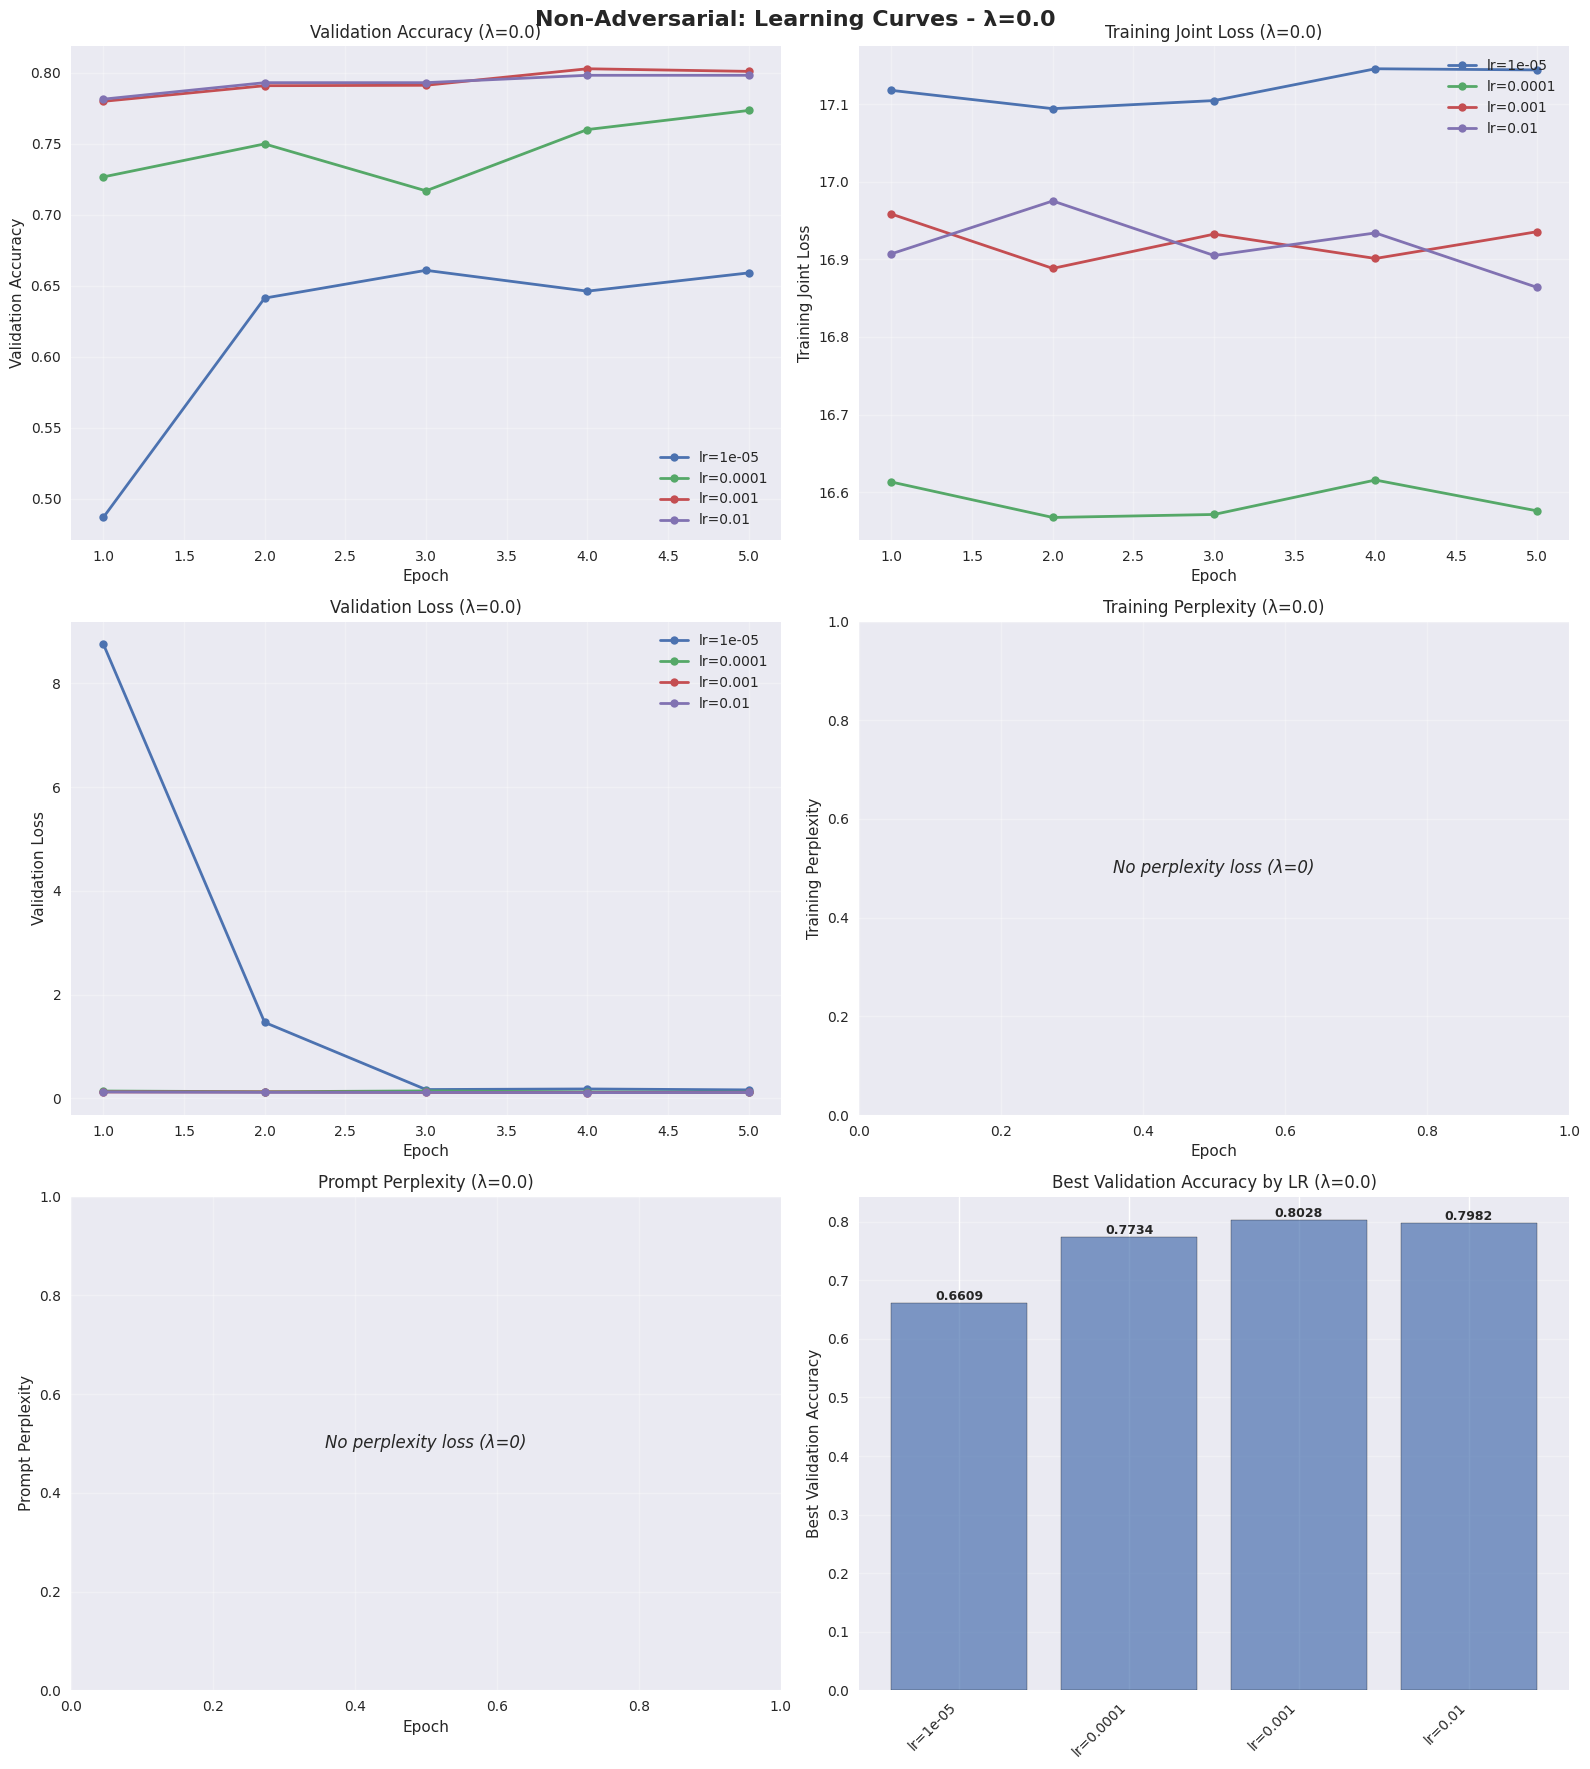

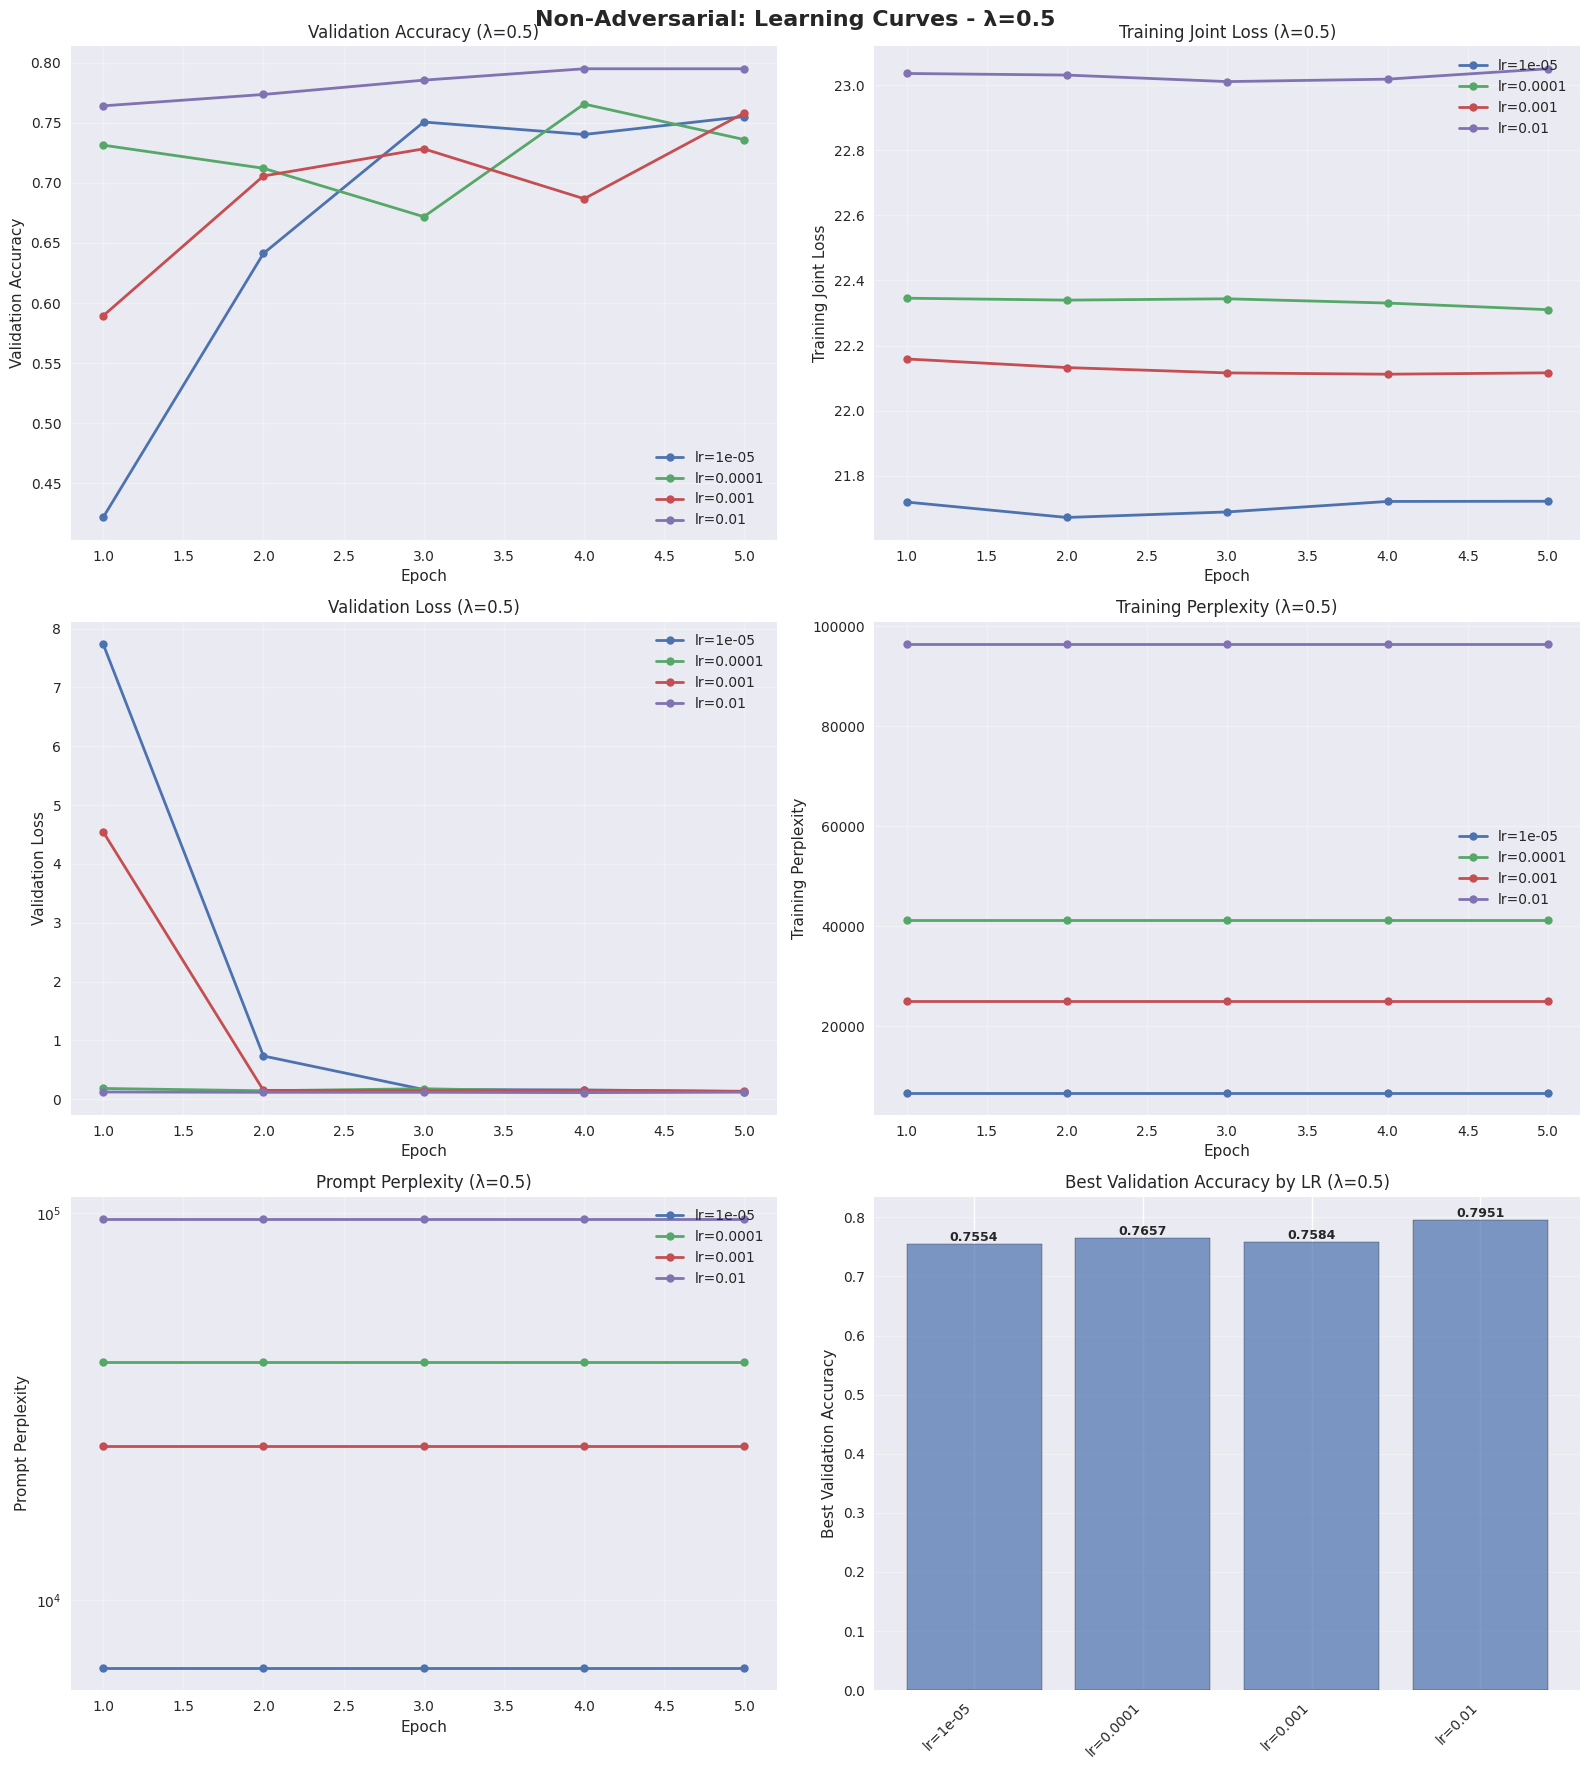

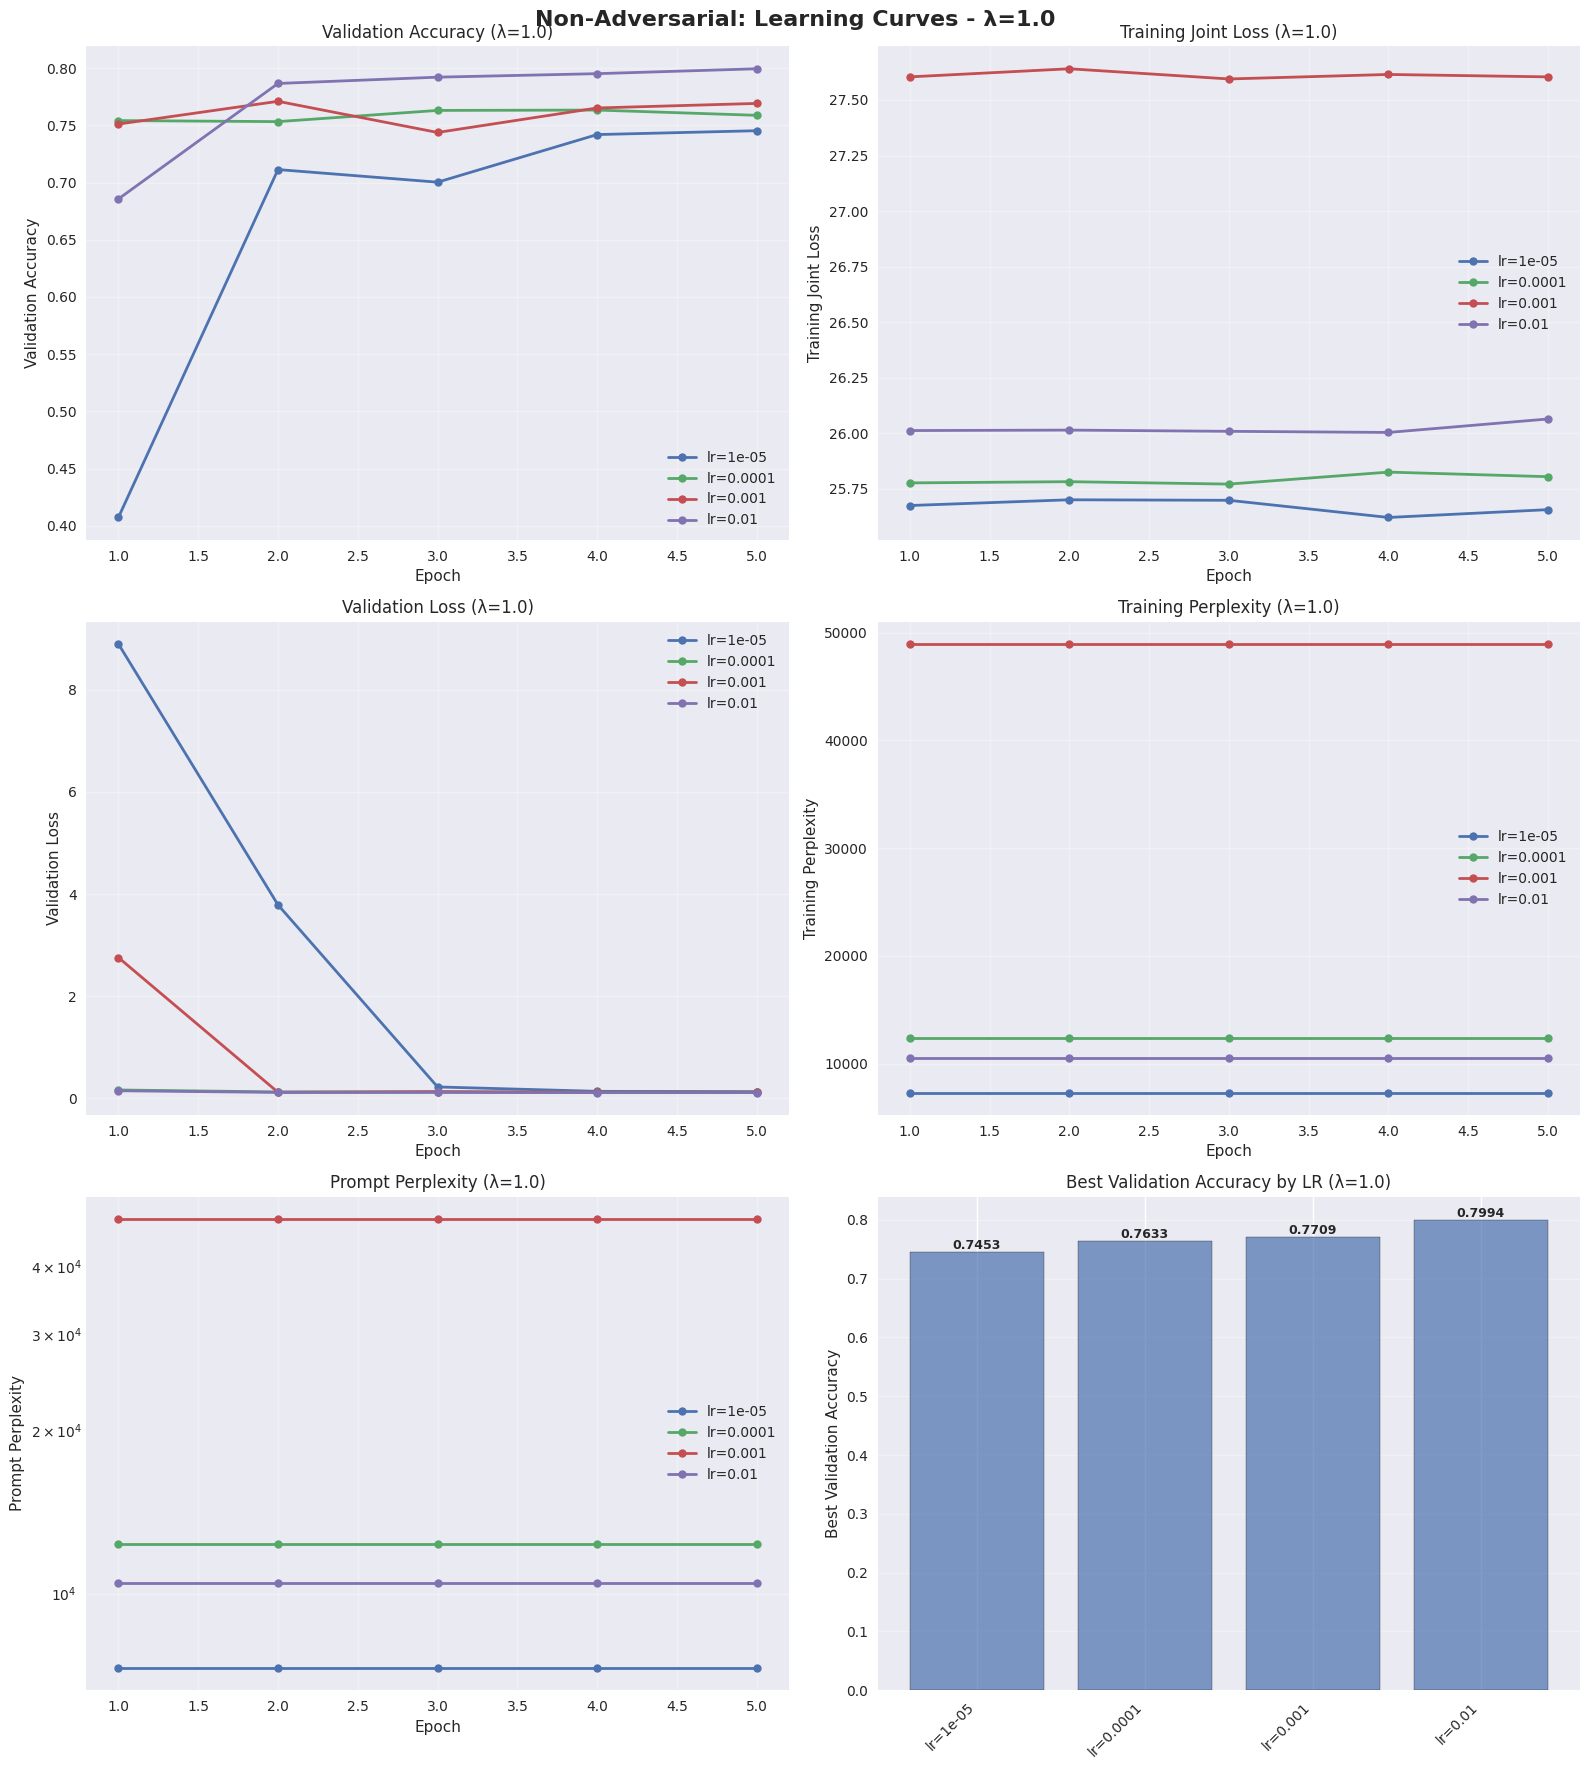

In [9]:
# Plot non-adversarial learning curves
print("Plotting non-adversarial learning curves...")
figs_non_adv = plot_learning_curves(non_adv_histories, title_prefix="Non-Adversarial: ")
for fig in figs_non_adv:
    plt.show()


Plotting adversarial learning curves...


/tmp/ipykernel_330920/1199782650.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend(fontsize=10)
/tmp/ipykernel_330920/1199782650.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax5.legend(fontsize=10)


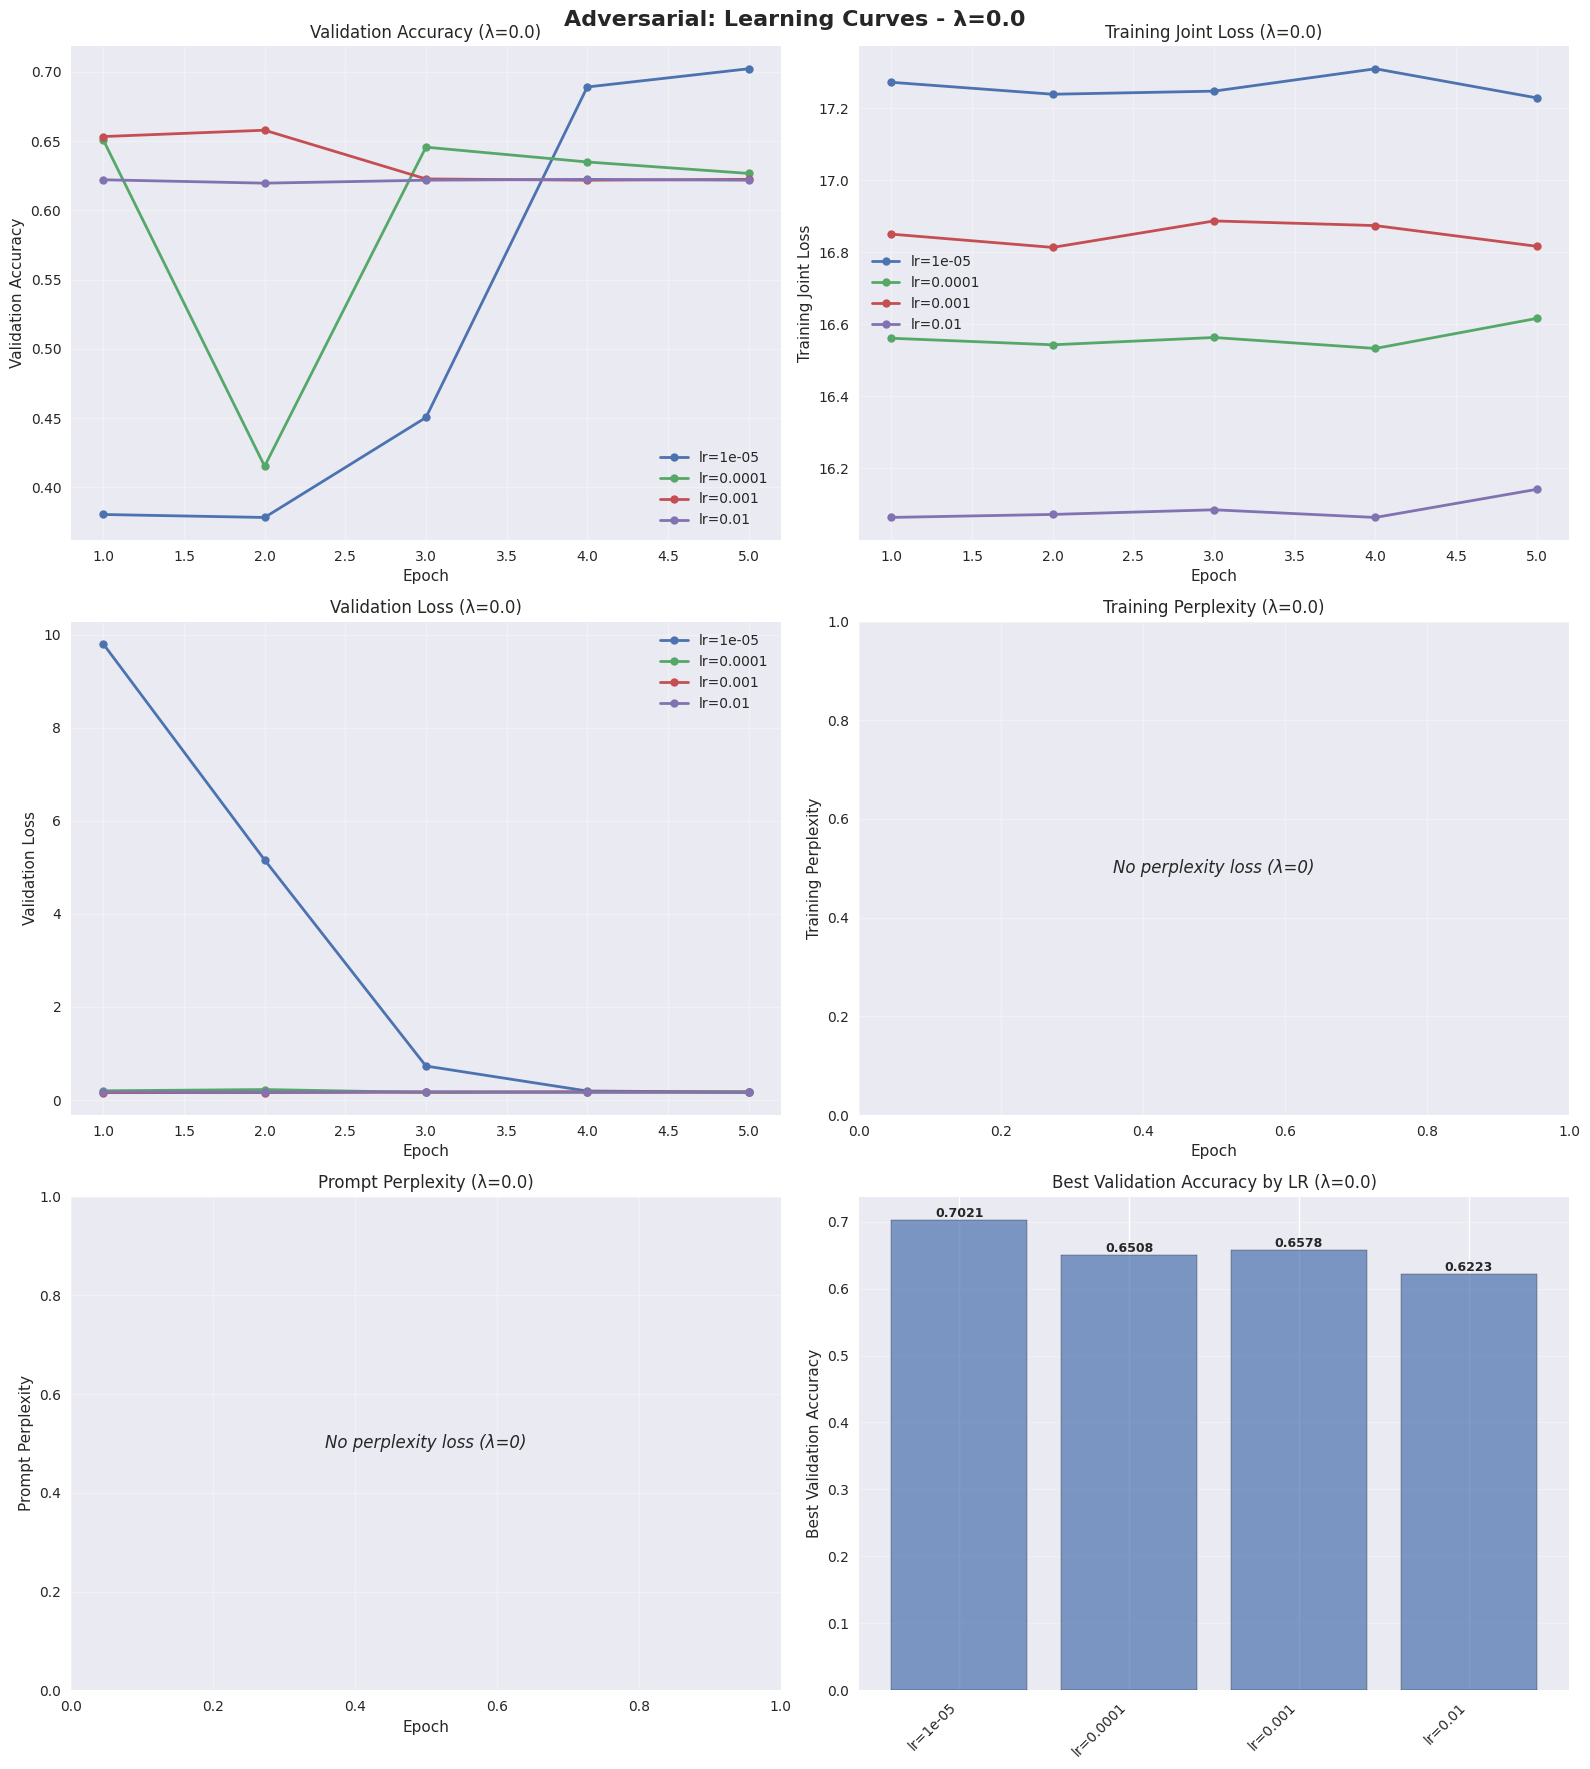

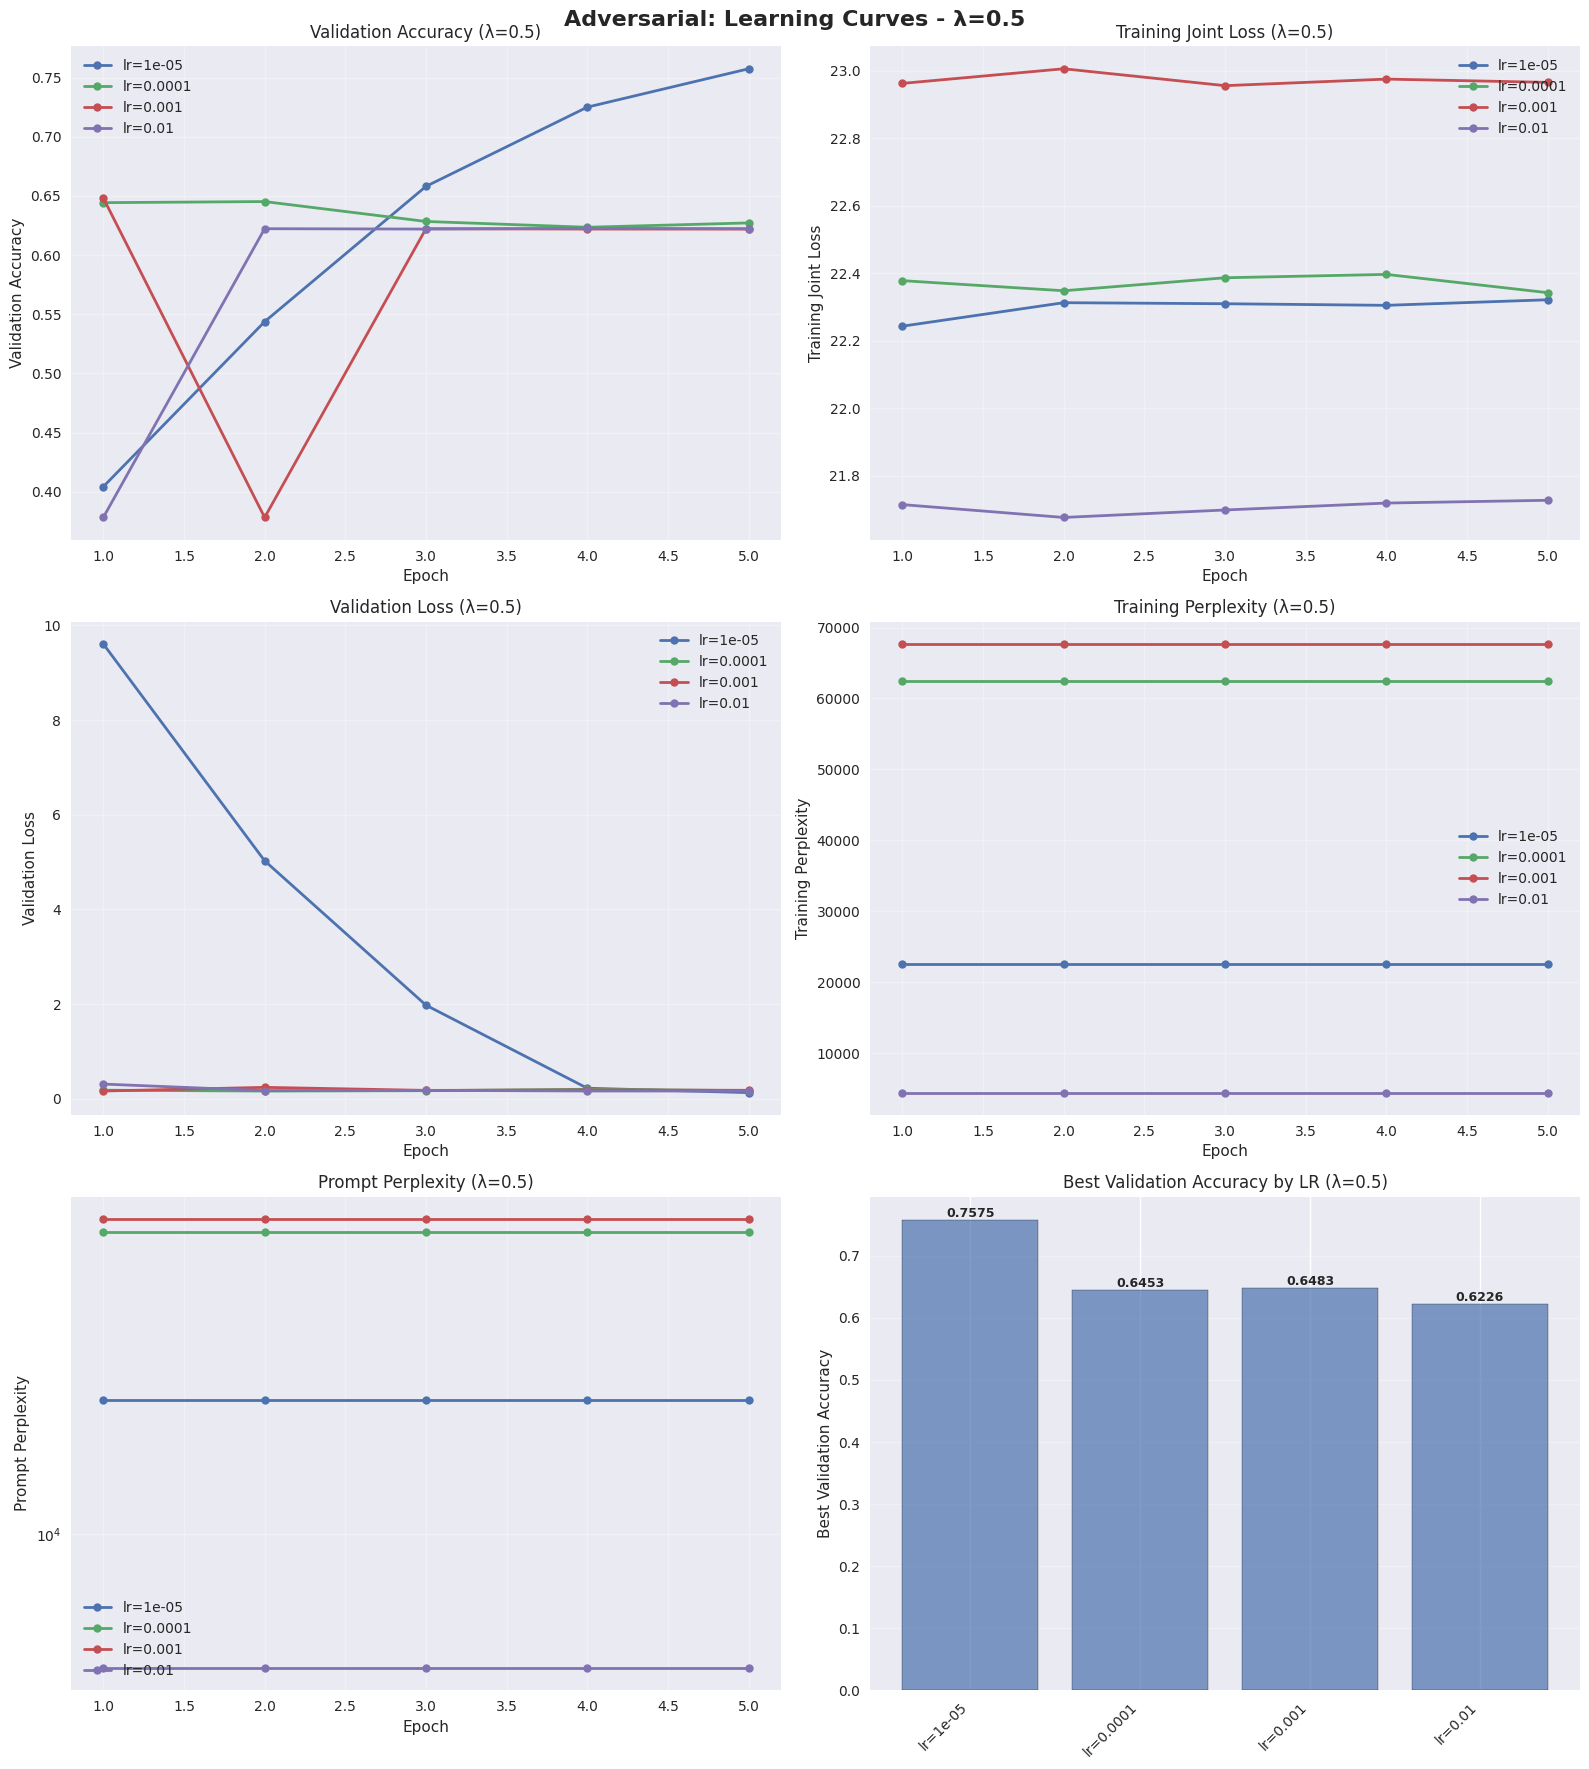

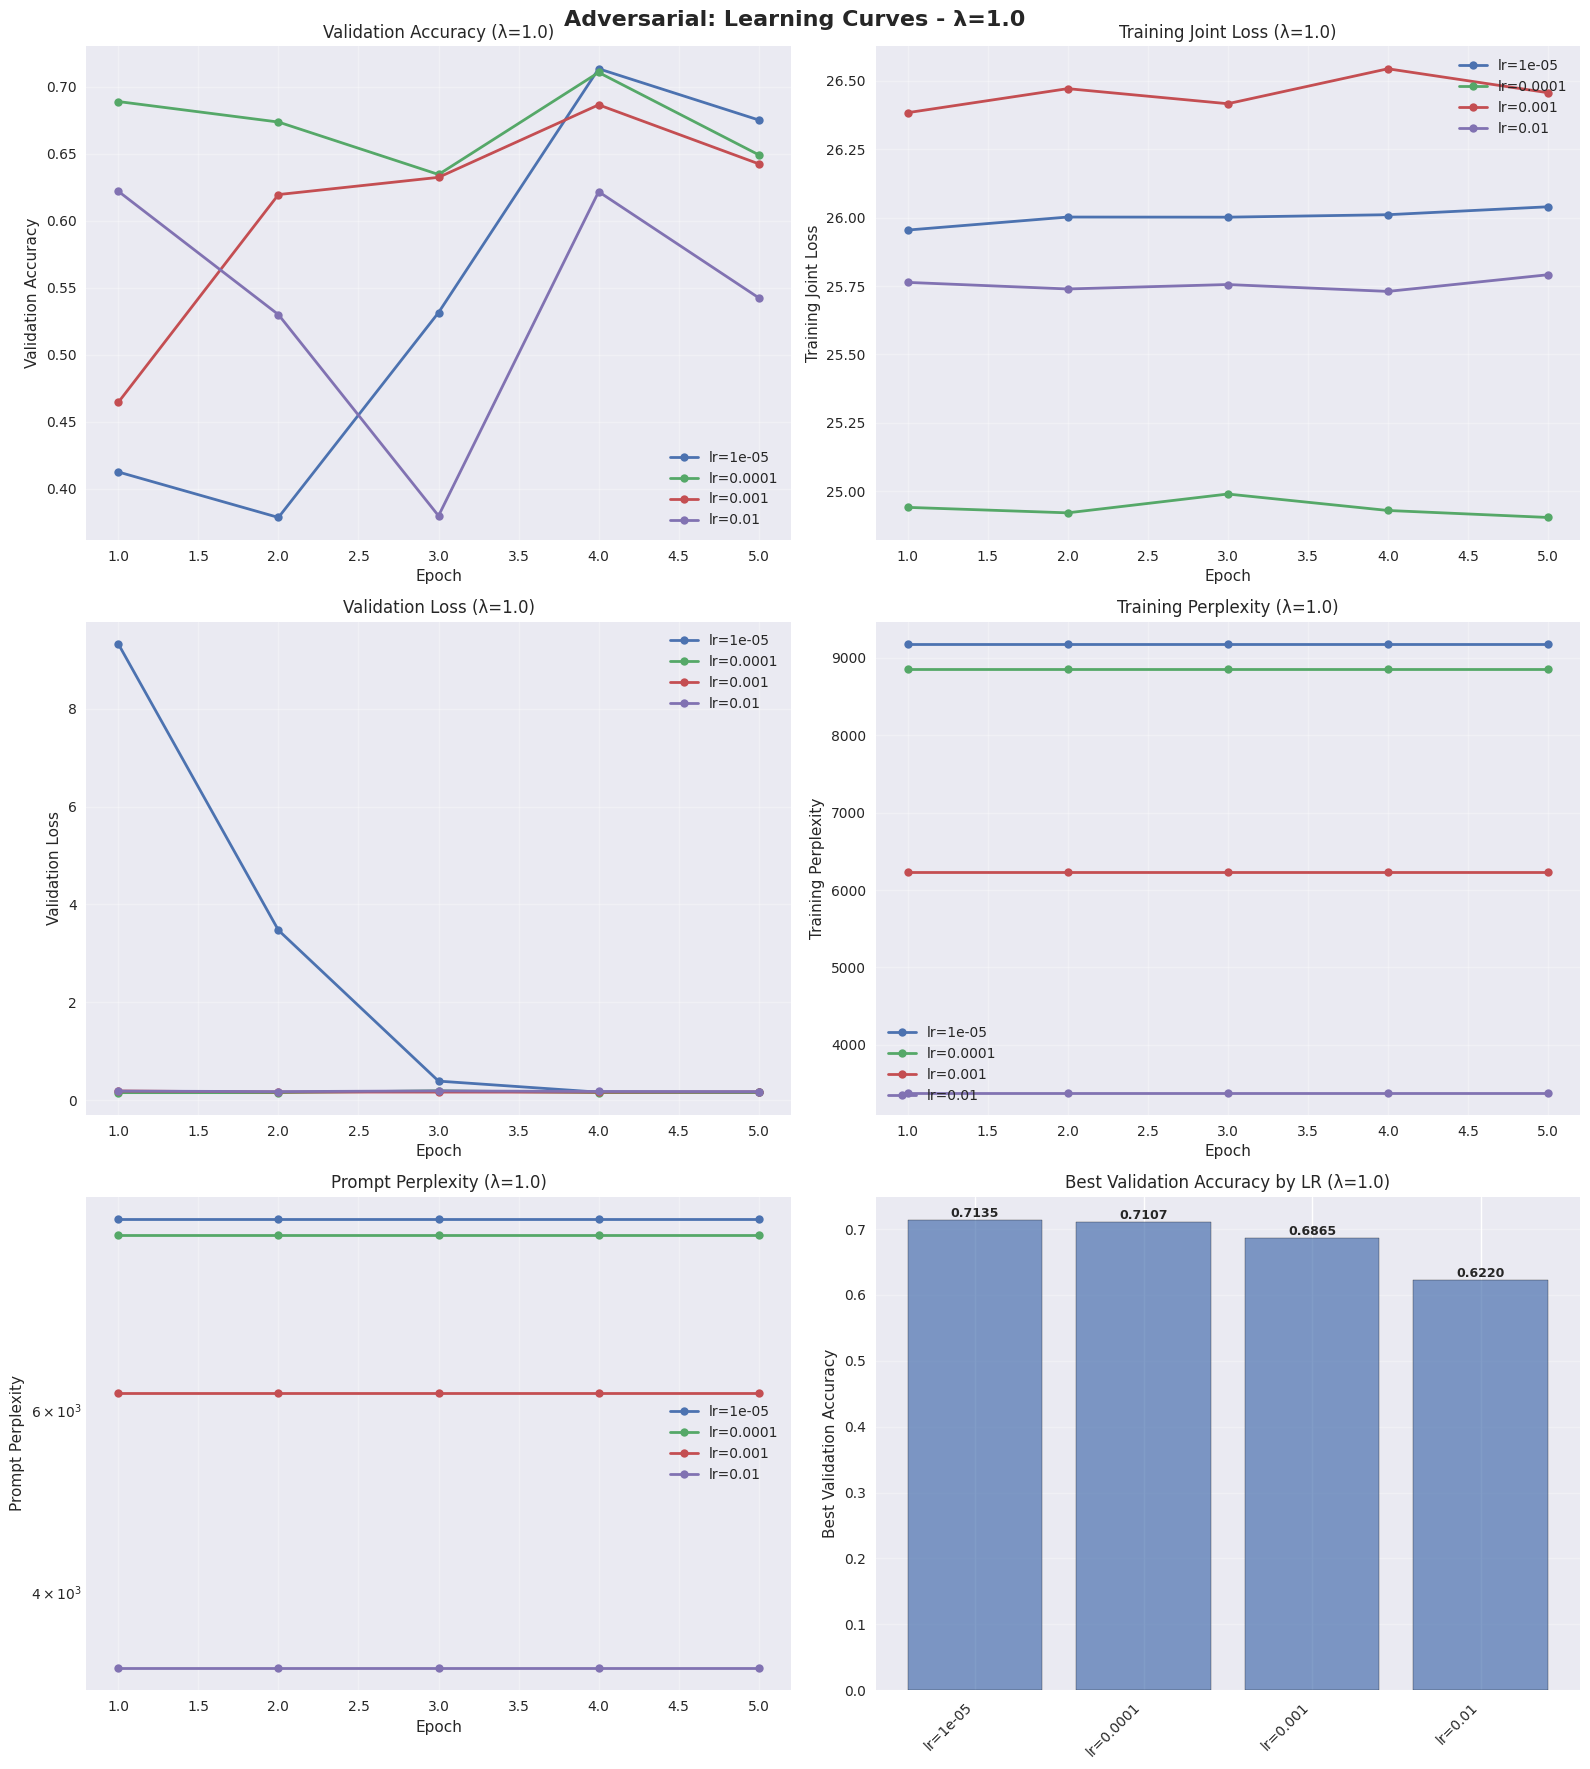

In [10]:
# Plot adversarial learning curves
print("Plotting adversarial learning curves...")
figs_adv = plot_learning_curves(adv_histories, title_prefix="Adversarial: ")
for fig in figs_adv:
    plt.show()
